# Heatmap: Best Sampler per Attribute (Wasserstein ↓)
This notebook aggregates your exported results and draws a readable heatmap.
- **Metric**: `global_median_wasserstein_distance` (lower is better)
- **Colors**: row-normalized, **green = better**, **red = worse**
- Stars mark the best sampler per attribute.

In [6]:
import os
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42  # embed TrueType fonts
mpl.rcParams["ps.fonttype"] = 42

# --- Configuration: folder lives next to this .ipynb ---
# If your folder name differs, change it here (e.g. "Heatmap_data")
DATA_ROOT = Path.cwd() / "Heatmap data"     # relative path
BASE = DATA_ROOT / "Single_attr_chain"

# Sanity check (optional)
if not BASE.exists():
    raise FileNotFoundError(
        f"Expected folder not found: {BASE}\n"
        "Tip: Put the 'Heatmap data' folder in the same directory as this notebook, "
        "or update DATA_ROOT to the correct path."
    )

# Mapping stays the same
attr_map = {
    "Dim": ("Dimension", "dimension"),
    "Corr": ("Correlation", "correlation"),
    "Tails": ("Tail weight (ν)", "nu"),
    "MM": ("Mode distance", "mm"),
}
sampler_name_map = {
    "HMC": "HMC",
    "Metro": "Metropolis",
    "DEMetro_Z": "DEMetropolisZ",
    "SMC": "SMC",
}

# Use BASE below instead of 'work_dir / ...'
base_dir = BASE


In [7]:

# --- Aggregate by mean Wasserstein over all values per attribute ---
records = []
for folder_key, (attr_name, attr_col) in attr_map.items():
    folder = base_dir / folder_key / "chain_results"
    for csv_path in folder.glob("Global_results_*.csv"):
        sampler_key = csv_path.stem.replace("Global_results_", "")
        sampler = sampler_name_map.get(sampler_key)
        if sampler is None:
            continue
        df = pd.read_csv(csv_path)
        # pick metric column
        metric_col = None
        for c in ["global_median_wasserstein_distance"]:   #   "global_mean_wasserstein_distance", "wasserstein_distance", "swd", "SWD"
            if c in df.columns:
                metric_col = c
                break
        if metric_col is None:
            continue

        # prefer chain if present
        dff = df
        if "evaluation_level" in df.columns:
            mask = df["evaluation_level"].astype(str).str.lower() == "chain"
            dff = df[mask] if mask.any() else df

        records.append({
            "Attribute": attr_name,
            "Sampler": sampler,
            "Mean_Wasserstein": dff[metric_col].mean(),
        })

agg_df = pd.DataFrame(records)
pivot = agg_df.pivot(index="Attribute", columns="Sampler", values="Mean_Wasserstein")\
             .reindex(index=["Dimension", "Correlation", "Tail weight (ν)", "Mode distance"],
                      columns=["Metropolis", "DEMetropolisZ", "HMC", "SMC"])

pivot.round(6)


Sampler,Metropolis,DEMetropolisZ,HMC,SMC
Attribute,,,,
Dimension,0.039147,5.063782,0.028179,0.027952
Correlation,0.089929,0.047068,0.031442,0.025729
Tail weight (ν),0.105039,0.129230,0.069108,0.141748
Mode distance,2.708388,2.864828,3.182663,0.079934


Saved:
- /home/fabian/python_files/MA/Heatmap_generator/Figures/chain_heatmap_WS_rownorm.pdf


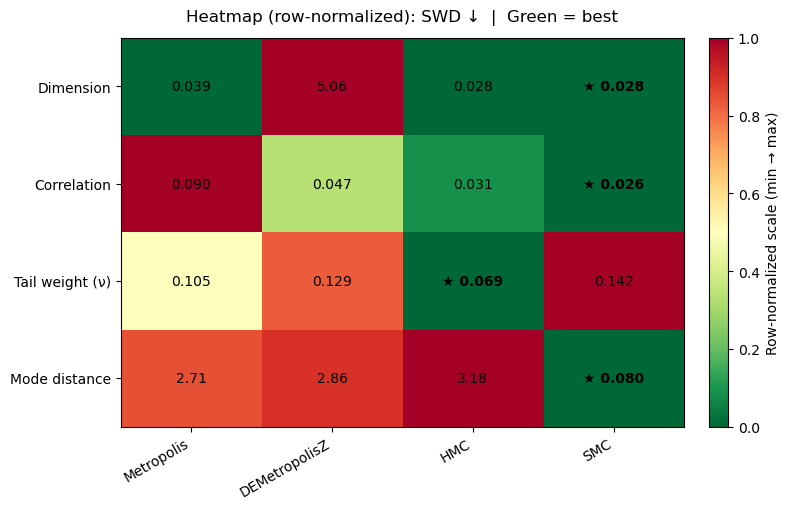

In [9]:

# --- Heatmap (row-normalized), green=best ---
data_raw = pivot.values.astype(float)

row_min = np.nanmin(data_raw, axis=1)
row_max = np.nanmax(data_raw, axis=1)
row_range = row_max - row_min
row_range[row_range == 0] = 1.0
data_scaled = (data_raw - row_min[:, None]) / row_range[:, None]

fig, ax = plt.subplots(figsize=(8, 5.2))
im = ax.imshow(data_scaled, aspect="auto", cmap="RdYlGn_r", vmin=0, vmax=1)

col_labels = list(pivot.columns)
row_labels = list(pivot.index)
ax.set_xticks(np.arange(len(col_labels)))
ax.set_xticklabels(col_labels, rotation=30, ha="right")
ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels)
ax.set_title("Heatmap (row-normalized): SWD ↓  |  Green = best", pad=12)

for i in range(data_raw.shape[0]):
    try:
        j_best = int(np.nanargmin(data_raw[i]))
    except ValueError:
        j_best = None
    for j in range(data_raw.shape[1]):
        val = data_raw[i, j]
        if np.isnan(val):
            txt = "–"
        else:
            txt = f"{val:.3f}" if val < 1 else f"{val:.2f}"
            if j_best is not None and j == j_best:
                txt = "★ " + txt
        ax.text(j, i, txt, ha="center", va="center", color="black", fontsize=10, fontweight="bold" if j==j_best else "normal")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Row-normalized scale (min → max)")


fig.tight_layout()

# --- Save next to the notebook ---
out_dir = Path.cwd()               # the folder where the .ipynb lives
out_pdf = out_dir / "Figures/chain_heatmap_WS_rownorm.pdf"

fig.savefig(out_pdf, bbox_inches="tight", format="pdf")  # vector PDF (imshow bitmap + vector text)
print(f"Saved:\n- {out_pdf}")